# HDS5210 Final

This final examination is similar in scale to the midterm from several weeks ago, but covers the scope of the entire semester.  The final also attempts to create a real-world scenario that you might encounter as a data scientist is the field.

<img src='final_datamodel.png' style="float:right; width:300px"/>

The data you need for the final includes the following:
* **rx_claims** - A relational database table that has a set of claims we will be calculating prices on.
* **drug_usage** - A relational database table that has a list of drug identifiers (NDC) and a category of disagnoses for which the drug is used.
* **npidata** - A relational database table that has a list of doctors and some information about them.
* **rx_rules** - A document collection in AWS DocumentDB that has a set of calculation rules that you will need to read and use in calculating prices.

*Note that ALL of the claim and drug data above is made up.  Those drugs aren't really used for those categories of usage and don't cost those amounts.*

As a form of shortcut, when the instructions say **cost** that means the **ingredient_cost** column in the rx_claims table.  When the instructions say **days** that refers to the **days_supply** column.


You will be asked to solve a number of different problems using this data.  As we've done in previous assignmnets, put `answer = <something>` at the end of each problem cell.  That will be used for autograding.

## Setup

The code below provides you with connections to both the MySQL database containing the relational tables for **rx_claims**, **npidata**, and **drug_usage**.  You can refer to that connection throughout your code with the variable `DB_CONN`.

The code also creates a connection to the AWS DocumentDB (e.g. MongoDB) that contains the rules for how rx_claims prices are calculated.  The variable `RX_RULES` contains a document collection that has two documents.  One with an `_id = 'N'` for rules for *new* prescriptions.  Another with an `_id = 'R'` for rules for *refill* prescriptions.

In [1]:
# Below are database connections and imports that you can use for the final.

import pandas as pd
import pymongo
import sys

# DocumentDB setup.  At the end of this, you'll a variable RX_RULES refering to a collection of rules that you can query
user = 'slucor2019'
password = 'SLUcor2019'
client = pymongo.MongoClient('mongodb://' + 
     user + ':' + 
     password + 
     '@slucor-2019.cgdcoitnku0k.us-east-1.docdb.amazonaws.com:27017/?ssl=true&sslAllowInvalidHostnames=true&ssl_ca_certs=/pem/rds-combined-ca-bundle.pem'
)

db = client.test
RX_RULES = db['rx_rules']

# MySQL Database Connection.  At the end of this, you'll have a connection in a variable called DB_CONN
# Then, this code will automatically setup your 
from sqlalchemy import create_engine
import pandas as pd

host = 'slucor2019.cgdcoitnku0k.us-east-1.rds.amazonaws.com'
port = '3306'
user = 'slucor2019'
password = 'SLUcor2019'
database = 'slucor2019'

DB_CONN = create_engine('mysql://' + 
                     user + ':' + 
                     password + '@' + 
                     host + ':' + 
                     str(port) + '/' + 
                     database)


/usr/local/lib64/python3.7/site-packages/pymongo/common.py:635: UserWarning: Unknown option sslAllowInvalidHostnames
  warnings.warn(str(exc))


## PART 1 - Average Daily Cost by Month

Each claim in **rx_claims** contains an **ingredient cost** and a **days supply**.  The **days supply** tells us how many days worth of medication this one prescription contains.  For this part, we are going to calculate the ingredient cost per day, meaning how much a single days supply costs.

Calculate the drug **ingredient cost** per **days supply** for each claim and then aggregate that by month and compute the average over a month.  Your result should be a data frame that has two columns: `month` and `avg_daily_cost`.

Provide your `avg_daily_cost` to the nearest 3 decimal places using code something like this:
```python
answer['avg_daily_cost'] = round(answer['avg_daily_cost'],3)
```

In [22]:
### BEGIN SOLUTION

# 1. Read the claims from the database
rx_claims = pd.read_sql_query("SELECT * FROM rx_claims", DB_CONN)

# 2. Compute the avg ingredient cost per days supply
rx_claims['avg_daily_cost'] = round(rx_claims['ingredient_cost'] / rx_claims['days_supply'],3)

# 3. Calculate the month
#    These dates are strings in the format YYYY-MM-DD hh:mm:ss, so we can just substring
rx_claims['month'] = rx_claims['clndr_date'].str[0:7]

# 4. Group by month and average the avg_daily_copst column
by_month = rx_claims.groupby('month')['avg_daily_cost'].mean().reset_index()

# 5. Round the results to 3 decimal places
by_month['avg_daily_cost'] = round(by_month['avg_daily_cost'],3)

answer = by_month

### END SOLUTION

In [23]:
assert(answer.shape == (2,2))
assert(round(answer[answer['month'] == '2018-01']['avg_daily_cost'].item(),1) == 2.0)

### BEGIN HIDDEN TESTS
assert(round(answer[answer['month'] == '2018-02']['avg_daily_cost'].item(),1) == 1.7)
### END HIDDEN TESTS

## PART 2 - Average Daily Cost by Drug Usage Category

Using the same definition of cost as in part 1, now we're going to calculate the average daily cost within drug usage category.  There is a table in the relational database called **drug_usage** that contains an **ndc** (National Drug Code) and **category**.

For this part, create a data frame that contains two columns: **drug_usage** and **avg_daily_cost**.  Again, round the average daily cost to 3 decimal places.

In [25]:
### BEGIN SOLUTION

# 1. Read the claims and drug usage from the database
rx_claims = pd.read_sql_query("SELECT * FROM rx_claims", DB_CONN)
drug_usage = pd.read_sql_query("SELECT * FROM drug_usage", DB_CONN)

# 2. Compute the avg ingredient cost per days supply
rx_claims['avg_daily_cost'] = round(rx_claims['ingredient_cost'] / rx_claims['days_supply'],3)

# 3. Join the claims and drug usage
rx_claims = rx_claims.merge(drug_usage, how='left', left_on='ndc', right_on='ndc')

# 4. Group by month and average the avg_daily_copst column
by_category = rx_claims.groupby('category')['avg_daily_cost'].mean().reset_index()

# 5. Round the results to 3 decimal places
by_category['avg_daily_cost'] = round(by_category['avg_daily_cost'],3)

answer = by_category

### END SOLUTION

In [26]:
assert(answer.shape == (7,2))
assert(round(answer[answer['category'] == 'blood pressure']['avg_daily_cost'].item(),1) == 0.1)
assert(round(answer[answer['category'] == 'cancer']['avg_daily_cost'].item(),1) == 3.9)

### BEGIN HIDDEN TESTS
assert(round(answer[answer['category'] == 'cholesterol']['avg_daily_cost'].item(),1) == 0.1)
assert(round(answer[answer['category'] == 'infection']['avg_daily_cost'].item(),1) == 0.2)
assert(round(answer[answer['category'] == 'inflammation']['avg_daily_cost'].item(),1) == 0.2)
assert(round(answer[answer['category'] == 'mental health']['avg_daily_cost'].item(),1) == 0.3)
assert(round(answer[answer['category'] == 'pain']['avg_daily_cost'].item(),1) == 0.0)
### END HIDDEN TESTS


## PART 3 - Average Daily Cost per State

In the database, there is a table called **npidata** that has information about the providers who prescribed these medications.  For this problem, let's take a look at the state those provider practice in and what the average daily cost is per state.

Your result should be a dataframe with two columns: **state_name** and **avg_daily_cost**.  As before, round those average daily costs to 3 decimal places.

In [27]:
### BEGIN SOLUTION

# 1. Read the claims and drug usage from the database
rx_claims = pd.read_sql_query("SELECT * FROM rx_claims", DB_CONN)
providers = pd.read_sql_query("SELECT * FROM npidata", DB_CONN)

# 2. Compute the avg ingredient cost per days supply
rx_claims['avg_daily_cost'] = round(rx_claims['ingredient_cost'] / rx_claims['days_supply'],3)

# 3. Join the claims and drug usage
rx_claims = rx_claims.merge(providers, how='left', left_on='npd_prescr_npi', right_on='npi')

# 4. Group by month and average the avg_daily_copst column
by_state = rx_claims.groupby('state_name')['avg_daily_cost'].mean().reset_index()

# 5. Round the results to 3 decimal places
by_state['avg_daily_cost'] = round(by_state['avg_daily_cost'],3)

answer = by_state

### END SOLUTION

In [28]:
assert(answer.shape == (3,2))
assert(round(answer[answer['state_name'] == 'IL']['avg_daily_cost'].item(),1) == 2.2)

### BEGIN HIDDEN TESTS
assert(round(answer[answer['state_name'] == 'MO']['avg_daily_cost'].item(),1) == 1.5)
assert(round(answer[answer['state_name'] == 'WY']['avg_daily_cost'].item(),1) == 0.9)
### END HIDDEN TESTS

## PART 4 - Calculting TOTAL Cost

<img src='final_rules.png' style="float:right; width:200px"/>

The cost in the **rx_claims** table is the **ingredient_cost**.  That means it only includes the cost to purchase the medication itself.  This cost does not include any additional information like administration fees, taxes, discounts, or rebates.  The rules for how these additional factors have to be included is stored in an AWS DocumentDB collection (sample shown to the right), and we're going to write a custom function that will calculate the total cost of a prescription based on the logic below and the specific business rules available in that DocumentDB collection.

Create a function called **total_cost(ingredient_cost, new_or_refill_code, cagetory)**.

This function will access the DocumentDB collection and retreive the rule set based on the **new_or_refill_code**.  You may want to refer back to module 50 examples for how to query the DocumentDB database.

The cost rules in the DocumentDB entries have two parts.  First, there is a **category_discount** based on the drug category in the drug_usage table. A **discounted_ingredient_cost** can be computed by multiplying the **ingredient_cost** by the discounting factor for that drug usage category.  Then, there is an **admin_fee** that simply has to be added to the newly **discounted_ingredient_cost** to get the **total_cost**.

Write your function to read from the DocumentDB database and calculate the total cost based on the three input parameters provided to the function as shown.  Have your function round the answer that is returned to 3 decimal places.

The autograder will test your function by calling it with a number of different parameters.


**HINT** Since we didn't do very much with DocumentDB, I'll give you some code that you can use to fetch a document from the database.  You'll have to adapt this to do exactly what you want inside your function, but it should give you a good example.

```python
rule = list(RX_RULES.find({'_id': 'N' }))[0]
```

1. This code calls `find()` on the `RX_RULES` connection to DocumentDB that was created for you in the setup code at the beginning of the final.  The `find()` function will return all the documents that match the provided filter criteria.
2. In this example, it filters on only those documents that have an `_id == 'N'`.  That is, it retrieves the document for **New** (`'N'`) prescriptions only.  You could use `'R'` for refills.  You can even just use a variable name in the place of `'N'` or `'R'`.
3. The code above converts the results from DocuemntDB into a list
4. Then the code retrieves the first element from that list of results.  In this case, you can assume that pulling the first result is what you want because there is only one document with an `_id == 'N'` and only one with an `_id == 'R'`.

What you'll find in the `rule` variable from the code above will be a Python dictionary with all of the factors you need to calculate total price for a **New** prescription.



In [29]:
def total_cost(ingredient_cost, new_or_refill_code, category):
### BEGIN SOLUTION

    # 1. Grab the rule from DocumentDB for this new/refill code
    rule = list(RX_RULES.find({'_id': new_or_refill_code }))[0]
    
    # 2. Apply the discount and add the admin fee
    discount = rule.get('category_discount').get(category)
    admin_fee = rule.get('admin_fee')
    total_cost = round((ingredient_cost * discount) + admin_fee,3)
    
    return total_cost
### END SOLUTION

In [30]:
assert(total_cost(1, 'N', 'cancer') == 0.82)
assert(total_cost(1, 'R', 'cancer') == 0.38)

### BEGIN HIDDEN TESTS
assert(total_cost(1, 'N', 'blood pressure') == 1.27)
assert(total_cost(1, 'N', 'mental health') == 1.22)
assert(total_cost(1, 'N', 'inflammation') == 1.22)
assert(total_cost(1, 'N', 'pain') == 1.31)
assert(total_cost(1, 'N', 'infection') == 1.07)
assert(total_cost(1, 'N', 'cholesterol') == 1.27)
assert(total_cost(1, 'R', 'blood pressure') == 1.03)
assert(total_cost(1, 'R', 'mental health') == 0.88)
assert(total_cost(1, 'R', 'inflammation') == 0.83)
assert(total_cost(1, 'R', 'pain') == 0.98)
assert(total_cost(1, 'R', 'infection') == 0.83)
assert(total_cost(1, 'R', 'cholesterol') == 1.03)
### END HIDDEN TESTS

## PART 5 - Calculating total cost for every claim

Now that we have a function that can be used to calculate a real total cost for each claim, we need to apply that to the claims.  For this part, we'll create a new data frame that has the claims, the usage category, and a calculated total cost using our `total_cost()` function.

To do this, we can use the dataframe `apply` function: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html

Your answer should be a dataframe from the **rx_claims** table, the additional **category** column from **drug_usage**, a **daily_cost** as previously described in early questions, a **total_cost** column, and a **daily_total_cost** column.  The **total_cost** column should have the new cost, rounded to two (2) decimal places.  The **daily_cost** and **daily_total_cost** should be the costs divided by days supply, and also be rounded to two (2) decimal places.

In [59]:
### BEGIN SOLUTION

# 1. Read the claims and drug usage from the database
rx_claims = pd.read_sql_query("SELECT * FROM rx_claims", DB_CONN)
drug_usage = pd.read_sql_query("SELECT * FROM drug_usage", DB_CONN)

# 2. Compute the ingredient cost per days supply
rx_claims['daily_cost'] = rx_claims['ingredient_cost'] / rx_claims['days_supply']

# 3. Join the claims and drug usage
rx_claims = rx_claims.merge(drug_usage, how='left', left_on='ndc', right_on='ndc')

# 4. Calculate our total cost (using the apply function)
rx_claims['total_cost'] = rx_claims.apply(
    lambda x: round(total_cost(x['ingredient_cost'], x['new_or_refill_code'], x['category']),2), 
    axis=1)

# 5. Compute the total cost per days supply
rx_claims['daily_total_cost'] = round(rx_claims['total_cost'] / rx_claims['days_supply'],2)

answer = rx_claims

### END SOLUTION

In [60]:
answer['total_cost'].sum()

17805.29

In [61]:
answer['daily_total_cost'].sum()

789.27

In [62]:
assert(answer.shape[0] == 1000)
assert(round(answer['total_cost'].sum(),0) == 17805)
assert(round(answer['daily_total_cost'].sum(),0) == 789)

### BEGIN HIDDEN TESTS
assert(round(answer[answer['category'] == 'blood pressure']['total_cost'].sum(),1) == 781)
assert(round(answer[answer['category'] == 'cancer']['total_cost'].sum(),1) == 15680)
### END HIDDEN TESTS



## PART 6 - Patterns in the data

The last part of the final is to see if we can visualize some of the patterns in the data.  If look back to the price calculation rules in the DocumentDB documents and think about the formula for calculating price, you might be able to tell that there will be some patterns in resulting data.  If we want to understand the nature of the business rule that is used to take **ingredient cost**, **category**, and **new / refill code** to produce a total cost, it's often useful to plot those two variables against each other.  

For this part of the final, you need to create two separate charts and answer a question.
1. For the first, create a scatterplot with **daily_cost** on the X axis and **daily_total_cost** on the Y axis.

You'll notice that this chart has a distinctive pattern, with what looks like multiple trend lines.  We need to identify what *column* of the data (aka *feature*, *field*, *attribute*) will allow us to distinguish between those trend lines.  (Note that this is either **category** or **new_or_refill_code** since those are the only other factors that are used in transforming **daily_cost** into **daily_total_cost**.

It would be helpful to be able to show this distinction visually.  You can do this a few different ways.  I would recommend looking at the **scatterplot** documentation for a way to either create separate plots or color the plots differently based on a particular column value.
2. Create another scatterplot that shows that distinction.  Again with **daily_cost** on the X axis and **daily_total_cost** on the Y axis.


Refer back to the `pandas-scatter` notebook from module-30 as well as the documentation from the **seaborn** module's **scatterplot** function.

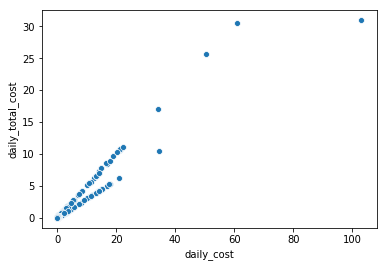

In [63]:
%matplotlib inline
import seaborn as sns

### BEGIN SOLUTION
sns.scatterplot(x='daily_cost', y='daily_total_cost', data=rx_claims)
### END SOLUTION

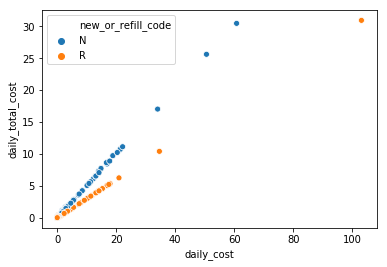

In [64]:
%matplotlib inline
import seaborn as sns

### BEGIN SOLUTION
sns.scatterplot(x='daily_cost', y='daily_total_cost', data=rx_claims, hue="new_or_refill_code")
### END SOLUTION

## PART 7 - Visualizing groupings

When you create a scatterplot with **daily_cost** on one axis and **daily_total_cost** the pattern it creates can be represented using a derivative.  (This is calculus, but I'm only explaining something here.  You don't have to do the calculus.)  In our case, you see a simple linear relationship between **daily_cost** and **daily_total_cost**.  Therefore, the ratio of **daily_total_cost** / **daily_cost** can be used to understand how other factors impact the relationship between **daily_cost** and **daily_total_cost**.

For this last section of the final, start by computing the ratio of **daily_total_cost** / **daily_cost**. Make this a new column in your answer dataframe called **ratio**.

Then run the category plot code provided in the cell after that.

Then answer some questions at the very end.

In [65]:
### BEGIN SOLUTION
rx_claims['ratio'] = rx_claims['daily_total_cost'] / rx_claims['daily_cost']
answer = rx_claims
### END SOLUTION

In [66]:
rx_claims.sort_values('daily_cost', ascending=True)

,rx_claim_number,npd_prescr_npi,ndc,prescription_count,clndr_date,new_or_refill_code,ingredient_cost,days_supply,daily_cost,category,total_cost,daily_total_cost,ratio
560,180034408328141999,1912900762,69618001710,1.0,2018-01-03 00:00:00.000000,N,0.14,30.0,0.004667,pain,0.46,0.02,4.285714
805,180123665660098999,1104829886,69618001710,1.0,2018-01-12 00:00:00.000000,R,0.14,30.0,0.004667,pain,0.21,0.01,2.142857
425,180385023452207999,1548263700,57896098110,1.0,2018-02-07 00:00:00.000000,R,0.16,30.0,0.005333,pain,0.22,0.01,1.875000
330,180370872362214999,1821091075,00536100901,1.0,2018-02-06 00:00:00.000000,R,0.20,30.0,0.006667,pain,0.26,0.01,1.500000
354,180536625350136999,1083617294,11822316910,1.0,2018-02-22 00:00:00.000000,R,0.23,30.0,0.007667,pain,0.29,0.01,1.304348
980,180153698009143998,1568465409,49348098023,1.0,2018-01-15 00:00:00.000000,N,0.23,30.0,0.007667,pain,0.55,0.02,2.608696
421,180506291425105999,1548263700,00603002632,1.0,2018-02-19 00:00:00.000000,N,0.23,30.0,0.007667,pain,0.55,0.02,2.608696
342,180396041404159997,1487657490,11822316910,1.0,2018-02-08 00:00:00.000000,N,0.23,30.0,0.007667,pain,0.55,0.02,2.608696
334,180546991039117999,1639172760,00603002632,1.0,2018-02-23 00:00:00.000000,N,0.23,30.0,0.007667,pain,0.55,0.02,2.608696
315,180043613348221998,1245233493,49348098023,1.0,2018-01-04 00:00:00.000000,R,0.23,30.0,0.007667,pain,0.29,0.01,1.304348


In [67]:
assert(round(answer['ratio'].sum(),0) == 763)
assert(round(answer['ratio'].mean(),1) == 0.8)

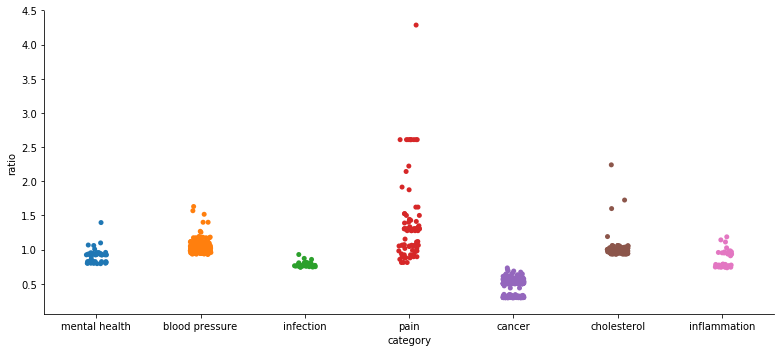

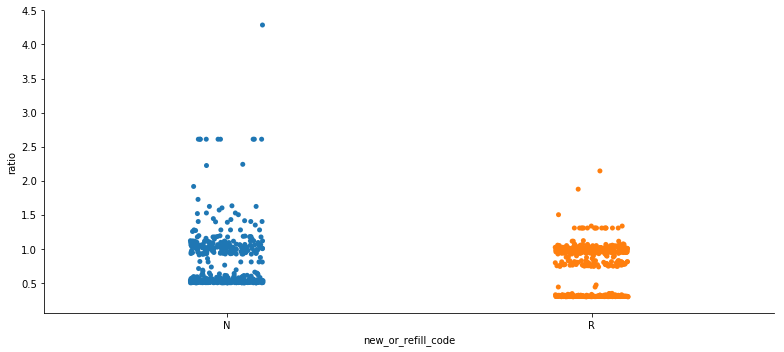

In [68]:
sns.catplot(data=answer, x='category', y='ratio', aspect=11/5, jitter=True)
sns.catplot(data=answer, x='new_or_refill_code', y='ratio', aspect=11/5, jitter=True)

**In the cell below, explain to the best of your ability what you can infer from the patterns you see in the plots above.  Can you explain the patterns that you see in the charts above based on how you implemented the `total_cost` function and what you see in the DocumentDB rules?**

I'm not looking for any one thing in particular here, just an idea of what you're able to understand abou the code you wrote and the configuration settings from the DocumentDB rules.

**double-click below where it says YOUR ANSWER HERE**

---



Something about seeing the stratifications.
Something else about seeing which categories were always higher/lower than others.